# SARIMAX

## Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors

<div class="alert alert-info"><h3>Related Functions:</h3>
<tt><strong>
<a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html'>sarimax.SARIMAX</a></strong><font color=black>(endog[, exog, order, …])</font>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<br>
<strong><a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.vector_ar.var_model.VARResults.html'>sarimax.SARIMAXResults</a></strong><font color=black>(model, params, …[, …])</font>&nbsp;&nbsp;Class to hold results from fitting a SARIMAX model.</tt>

<h3>For Further Reading:</h3>
<strong>
<a href='https://www.statsmodels.org/stable/statespace.html'>Statsmodels Tutorial:</a></strong>&nbsp;&nbsp;<font color=black>Time Series Analysis by State Space Methods</font><br>
<strong>
<a href='https://www.statsmodels.org/devel/examples/notebooks/generated/statespace_sarimax_stata.html'>Statsmodels Example:</a></strong>&nbsp;&nbsp;<font color=black>SARIMAX</font></div>

## Perform standard imports and load datasets

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")



In [12]:
# Load bank AK00100001_06MCD10K datasets
df = pd.read_csv('AK00100001_06MCD10K.csv')
df['surveydate']=pd.to_datetime(df['surveydate'])
df.set_index('surveydate',inplace=True)
df=df.asfreq('W-WED')
df=df.fillna(method = 'ffill', axis = 0) # fill the 8 NaN value with forwarding values 
df=df.drop(columns=['accountnumber','productcode','INST_NM','branchType'])
df.head()

,rate
surveydate,
1999-10-27,4.86
1999-11-03,4.86
1999-11-10,4.86
1999-11-17,4.76
1999-11-24,4.76


In [9]:
#Load 10 year Treasury rates (constant maturity).  

TR10 = pd.read_csv('WGS10YR.csv')
TR10['DATE']=pd.to_datetime(TR10['DATE'])
TR10.set_index('DATE',inplace=True)

TR10_1=TR10.loc['1999-10-29':'2018-05-09']

TR10_1=TR10_1.asfreq('W-FRI')

TR10_1.set_index(df.index,inplace=True)
TR10=TR10_1
TR10.head()

,WGS10YR
surveydate,
1999-10-27,6.16
1999-11-03,6.00
1999-11-10,5.96
1999-11-17,6.02
1999-11-24,6.10


In [10]:
# Load 1 year Treasury rates (constant maturity).  
TR1 = pd.read_csv('WGS1YR.csv')
TR1['DATE']=pd.to_datetime(TR1['DATE'])
TR1.set_index('DATE',inplace=True)

TR1_1=TR1.loc['1999-10-29':'2018-05-09']

TR1_1=TR1_1.asfreq('W-FRI')

TR1_1.set_index(df.index,inplace=True)
TR1=TR1_1
TR1.head()

,WGS1YR
surveydate,
1999-10-27,5.51
1999-11-03,5.45
1999-11-10,5.50
1999-11-17,5.56
1999-11-24,5.65


In [11]:
# Load Federal funds rate 

FR = pd.read_csv('FF.csv')
FR['DATE']=pd.to_datetime(FR['DATE'])
FR.set_index('DATE',inplace=True)

FR_1=FR.loc['1999-10-27':'2018-05-02']

FR1_1=FR_1.asfreq('W-WED')

FR=FR1_1
FR.head()

,FF
DATE,
1999-10-27,5.18
1999-11-03,5.27
1999-11-10,5.20
1999-11-17,5.44
1999-11-24,5.52


In [13]:
df = df.join(TR1).join(TR10).join(FR)
df.head()

,rate,WGS1YR,WGS10YR,FF
surveydate,,,,
1999-10-27,4.86,5.51,6.16,5.18
1999-11-03,4.86,5.45,6.00,5.27
1999-11-10,4.86,5.50,5.96,5.20
1999-11-17,4.76,5.56,6.02,5.44
1999-11-24,4.76,5.65,6.10,5.52


### Plot the source data

In [14]:
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
# For Notebooks
init_notebook_mode(connected=True)
# For offline use
cf.go_offline()

In [15]:
df.iplot()

### Run an ETS Decomposition

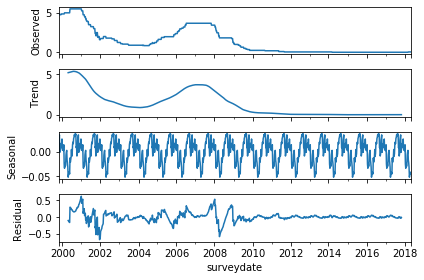

In [16]:
result = seasonal_decompose(df['rate'])
result.plot();

## Test for stationarity

In [107]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [18]:
adf_test(df['rate'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -2.537717
p-value                   0.106565
# lags used              19.000000
# observations          947.000000
critical value (1%)      -3.437274
critical value (5%)      -2.864597
critical value (10%)     -2.568398
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


### Run <tt>pmdarima.auto_arima</tt> to obtain recommended orders
This may take awhile as there are a lot of combinations to evaluate.

In [19]:
# For SARIMA Orders we set seasonal=True and pass in an m value
auto_arima(df['rate'],seasonal=True,m=52).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  967
Model:               SARIMAX(2, 1, 1)   Log Likelihood                1310.568
Date:                Mon, 19 Aug 2019   AIC                          -2611.136
Time:                        10:25:39   BIC                          -2586.770
Sample:                             0   HQIC                         -2601.860
                                - 967                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -4.135e-05      0.000     -0.159      0.874      -0.001       0.000
ar.L1          0.8541      0.056     15.252      0.000       0.744       0.964
ar.L2          0.1064      0.047      2.255      0.024       0.014       0.199
ma.L1         -0.9017      0.019    -46.443      0.000      -0.940      -0.864
sigma2         0.0038   4.93e-05     78.097      0.000       0.004       0.004
===================================================================================
Ljung-Box (Q):                      104.96   Jarque-Bera (JB):             49442.68
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.00   Skew:                            -2.35
Prob(H) (two-sided):                  0.00   Kurtosis:                        37.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""


### Split the data into train/test sets
We'll assign 1 year (52 weeks) to the test set 

In [20]:
len(df)

967

In [22]:
# Set four weeks for testing
train = df.iloc[:len(df)-52]
test = df.iloc[len(df)-52:]

### Fit a SARIMA(2,1,1) Model
NOTE: To avoid a <tt>ValueError: non-invertible starting MA parameters found</tt> we're going to set <tt>enforce_invertibility</tt> to False.

In [23]:
model = SARIMAX(train['rate'],order=(2,1,1),enforce_invertibility=False)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                   rate   No. Observations:                  915
Model:               SARIMAX(2, 1, 1)   Log Likelihood                1215.137
Date:                Mon, 19 Aug 2019   AIC                          -2422.274
Time:                        10:28:36   BIC                          -2403.002
Sample:                    10-27-1999   HQIC                         -2414.917
                         - 05-03-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8729      0.057     15.309      0.000       0.761       0.985
ar.L2          0.0998      0.050      1.997      0.046       0.002       0.198
ma.L1         -0.9153      0.017    -54.351      0.000      -0.948      -0.882
sigma2         0.0041   5.41e-05     75.715      0.000       0.004       0.004
===================================================================================
Ljung-Box (Q):                       97.98   Jarque-Bera (JB):             40373.81
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.00   Skew:                            -2.22
Prob(H) (two-sided):                  0.00   Kurtosis:                        35.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [24]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False).rename('SARIMA(2,1,1) Predictions')

Passing <tt>dynamic=False</tt> means that forecasts at each point are generated using the full history up to that point (all lagged values).

For more information on these arguments visit https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMAResults.predict.html

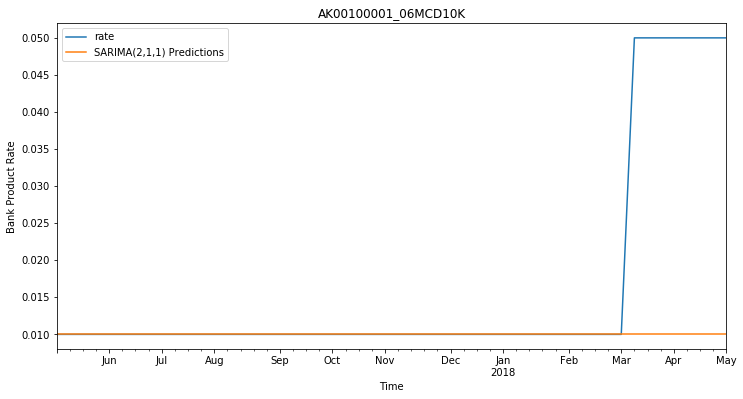

In [25]:
# Plot predictions against known values
# DON'T WRITE HERE
title='AK00100001_06MCD10K'
ylabel='Bank Product Rate'
xlabel='Time'

ax = test['rate'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);


### Evaluate the Model

In [26]:
from statsmodels.tools.eval_measures import mse,rmse

error1 = mse(test['rate'], predictions)
error2 = rmse(test['rate'], predictions)

print(f'SARIMA(2,1,1) MSE Error: {error1:11.10}')
print(f'SARIMA(2,1,1) RMSE Error: {error2:11.10}')

SARIMA(2,1,1) MSE Error: 0.0002461542697
SARIMA(2,1,1) RMSE Error: 0.01568930431


## Now add the exog variable-FF

In [27]:
auto_arima(df['rate'],exogenous=df[['FF']],seasonal=True,m=52).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  967
Model:               SARIMAX(5, 1, 1)   Log Likelihood                1334.118
Date:                Mon, 19 Aug 2019   AIC                          -2650.235
Time:                        11:14:14   BIC                          -2606.377
Sample:                             0   HQIC                         -2633.538
                                - 967                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0005      0.001     -0.867      0.386      -0.002       0.001
x1             0.0955      0.010      9.997      0.000       0.077       0.114
ar.L1          0.6866      0.062     11.036      0.000       0.565       0.809
ar.L2          0.0611      0.037      1.653      0.098      -0.011       0.133
ar.L3         -0.0106      0.021     -0.505      0.614      -0.052       0.030
ar.L4          0.0296      0.018      1.674      0.094      -0.005       0.064
ar.L5          0.1221      0.018      6.899      0.000       0.087       0.157
ma.L1         -0.7779      0.046    -16.964      0.000      -0.868      -0.688
sigma2         0.0037   5.04e-05     73.390      0.000       0.004       0.004
===================================================================================
Ljung-Box (Q):                       67.84   Jarque-Bera (JB):             46764.52
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.00   Skew:                            -2.32
Prob(H) (two-sided):                  0.00   Kurtosis:                        36.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [68]:
model = SARIMAX(train['rate'],exog=train['FF'],order=(5,1,1),enforce_invertibility=False)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                   rate   No. Observations:                  915
Model:               SARIMAX(5, 1, 1)   Log Likelihood                1236.990
Date:                Mon, 19 Aug 2019   AIC                          -2457.980
Time:                        12:38:40   BIC                          -2419.437
Sample:                    10-27-1999   HQIC                         -2443.267
                         - 05-03-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
FF             0.0967      0.010      9.572      0.000       0.077       0.117
ar.L1          0.6912      0.061     11.271      0.000       0.571       0.811
ar.L2          0.0651      0.039      1.685      0.092      -0.011       0.141
ar.L3         -0.0070      0.022     -0.316      0.752      -0.050       0.036
ar.L4          0.0306      0.019      1.649      0.099      -0.006       0.067
ar.L5          0.1253      0.018      6.797      0.000       0.089       0.161
ma.L1         -0.7862      0.044    -18.043      0.000      -0.872      -0.701
sigma2         0.0039   5.49e-05     71.230      0.000       0.004       0.004
===================================================================================
Ljung-Box (Q):                       64.48   Jarque-Bera (JB):             38431.99
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               0.00   Skew:                            -2.20
Prob(H) (two-sided):                  0.00   Kurtosis:                        34.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [69]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
exog_forecast = test[['FF']]   # requires two brackets for exogenous
predictions_FF = results.predict(start=start, end=end, exog=exog_forecast).rename('SARIMAX(5,1,1) Predictions')

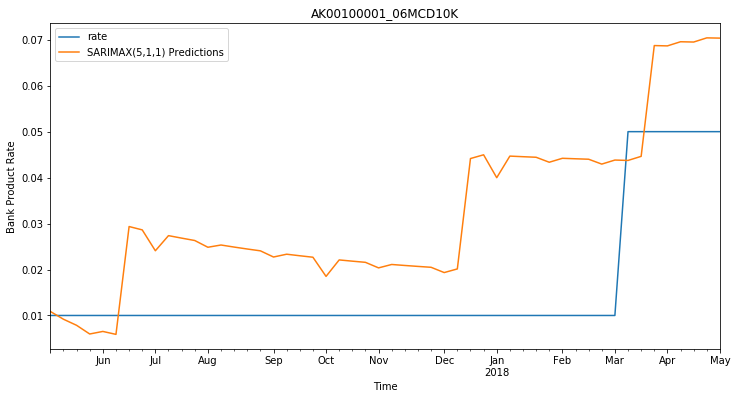

In [70]:
# Plot predictions against known values
title='AK00100001_06MCD10K'
ylabel='Bank Product Rate'
xlabel='Time'

ax = test['rate'].plot(legend=True,figsize=(12,6),title=title)
predictions_FF.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);


## Now add the exog variable-WGS1YR

In [42]:
auto_arima(df['rate'],exogenous=df[['WGS1YR']],seasonal=True,m=52).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  967
Model:               SARIMAX(3, 1, 2)   Log Likelihood                1312.646
Date:                Mon, 19 Aug 2019   AIC                          -2609.292
Time:                        11:38:27   BIC                          -2570.307
Sample:                             0   HQIC                         -2594.450
                                - 967                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0002      0.000     -0.491      0.623      -0.001       0.001
x1            -0.0692      0.020     -3.406      0.001      -0.109      -0.029
ar.L1         -0.0492      0.108     -0.454      0.650      -0.261       0.163
ar.L2          0.9127      0.074     12.312      0.000       0.767       1.058
ar.L3          0.0931      0.048      1.937      0.053      -0.001       0.187
ma.L1         -0.0021      0.095     -0.022      0.982      -0.188       0.184
ma.L2         -0.8310      0.085     -9.759      0.000      -0.998      -0.664
sigma2         0.0039   5.11e-05     75.502      0.000       0.004       0.004
===================================================================================
Ljung-Box (Q):                       96.34   Jarque-Bera (JB):             45039.10
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.00   Skew:                            -2.00
Prob(H) (two-sided):                  0.00   Kurtosis:                        36.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [43]:
model = SARIMAX(train['rate'],exog=train['WGS1YR'],order=(3,1,2),enforce_invertibility=False)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                   rate   No. Observations:                  915
Model:               SARIMAX(3, 1, 2)   Log Likelihood                1195.814
Date:                Mon, 19 Aug 2019   AIC                          -2377.628
Time:                        11:40:05   BIC                          -2343.903
Sample:                    10-27-1999   HQIC                         -2364.754
                         - 05-03-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
WGS1YR        -0.0463      0.026     -1.764      0.078      -0.098       0.005
ar.L1          0.1957      0.351      0.558      0.577      -0.492       0.884
ar.L2          0.2553      0.264      0.967      0.334      -0.262       0.773
ar.L3          0.0789      0.042      1.885      0.059      -0.003       0.161
ma.L1         -1.6241      0.921     -1.763      0.078      -3.430       0.182
ma.L2         -0.6141      0.730     -0.842      0.400      -2.044       0.816
sigma2         0.0011      0.001      1.811      0.070   -8.68e-05       0.002
===================================================================================
Ljung-Box (Q):                      148.46   Jarque-Bera (JB):             45830.74
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.00   Skew:                            -2.59
Prob(H) (two-sided):                  0.00   Kurtosis:                        37.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [49]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
exog_forecast = test[['WGS1YR']]  
predictions_1YR = results.predict(start=start, end=end, exog=exog_forecast).rename('SARIMAX(3,1,2) Predictions')

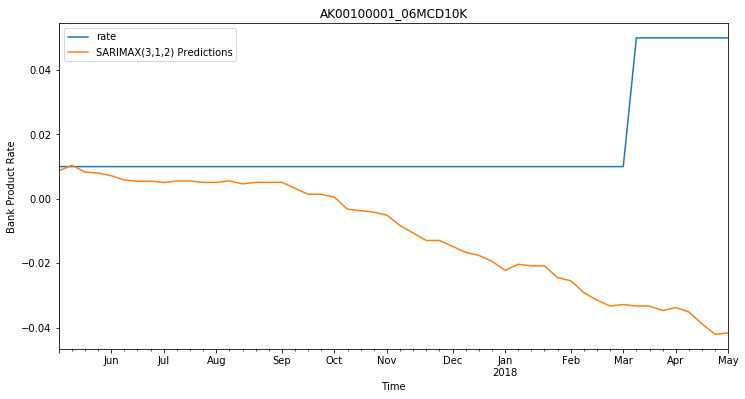

In [50]:
# DON'T WRITE HERE
title='AK00100001_06MCD10K'
ylabel='Bank Product Rate'
xlabel='Time'

ax = test['rate'].plot(legend=True,figsize=(12,6),title=title)
predictions_1YR.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

## Now add the exog variable-WGS10YR

In [53]:
auto_arima(df['rate'],exogenous=df[['WGS10YR']],seasonal=True,m=52).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  967
Model:               SARIMAX(1, 0, 0)   Log Likelihood                1280.425
Date:                Mon, 19 Aug 2019   AIC                          -2552.850
Time:                        12:08:11   BIC                          -2533.353
Sample:                             0   HQIC                         -2545.427
                                - 967                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0009      0.004      0.204      0.838      -0.008       0.010
x1            -0.0301      0.015     -1.947      0.052      -0.060       0.000
ar.L1          0.9996      0.002    623.107      0.000       0.996       1.003
sigma2         0.0041   4.71e-05     87.391      0.000       0.004       0.004
===================================================================================
Ljung-Box (Q):                      240.36   Jarque-Bera (JB):             50366.75
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.00   Skew:                            -2.86
Prob(H) (two-sided):                  0.00   Kurtosis:                        37.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [54]:
model = SARIMAX(train['rate'],exog=train['WGS10YR'],order=(1,0,0),enforce_invertibility=False)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                   rate   No. Observations:                  915
Model:               SARIMAX(1, 0, 0)   Log Likelihood                1185.857
Date:                Mon, 19 Aug 2019   AIC                          -2365.714
Time:                        12:12:40   BIC                          -2351.258
Sample:                    10-27-1999   HQIC                         -2360.196
                         - 05-03-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
WGS10YR       -0.0302      0.016     -1.891      0.059      -0.062       0.001
ar.L1          0.9998      0.000   3466.417      0.000       0.999       1.000
sigma2         0.0043    5.2e-05     83.511      0.000       0.004       0.004
===================================================================================
Ljung-Box (Q):                      228.35   Jarque-Bera (JB):             42164.12
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.00   Skew:                            -2.77
Prob(H) (two-sided):                  0.00   Kurtosis:                        35.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [55]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
exog_forecast = test[['WGS10YR']]  
predictions_10YR = results.predict(start=start, end=end, exog=exog_forecast).rename('SARIMAX(1,0,0) Predictions')

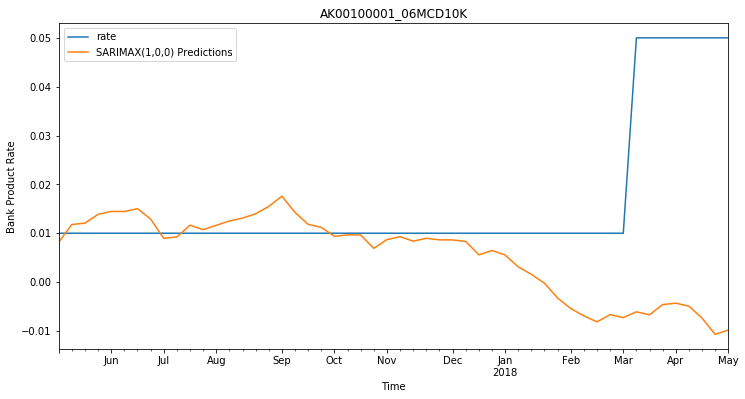

In [56]:
# DON'T WRITE HERE
title='AK00100001_06MCD10K'
ylabel='Bank Product Rate'
xlabel='Time'

ax = test['rate'].plot(legend=True,figsize=(12,6),title=title)
predictions_10YR.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

## Now add the exog variable-WGS10YR and WGS1YR

In [57]:
auto_arima(df['rate'],exogenous=df[['WGS10YR','WGS1YR']],seasonal=True,m=52).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  967
Model:               SARIMAX(5, 1, 1)   Log Likelihood                1323.712
Date:                Mon, 19 Aug 2019   AIC                          -2627.424
Time:                        12:26:37   BIC                          -2578.693
Sample:                             0   HQIC                         -2608.872
                                - 967                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0007      0.001     -0.882      0.378      -0.002       0.001
x1            -0.0356      0.021     -1.681      0.093      -0.077       0.006
x2             0.0172      0.022      0.772      0.440      -0.027       0.061
ar.L1          0.6423      0.056     11.417      0.000       0.532       0.753
ar.L2          0.0625      0.034      1.864      0.062      -0.003       0.128
ar.L3         -0.0168      0.023     -0.736      0.461      -0.061       0.028
ar.L4          0.0230      0.017      1.322      0.186      -0.011       0.057
ar.L5          0.1608      0.019      8.578      0.000       0.124       0.198
ma.L1         -0.7233      0.045    -15.943      0.000      -0.812      -0.634
sigma2         0.0038    5.1e-05     74.165      0.000       0.004       0.004
===================================================================================
Ljung-Box (Q):                       63.24   Jarque-Bera (JB):             42259.48
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               0.00   Skew:                            -2.26
Prob(H) (two-sided):                  0.00   Kurtosis:                        35.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [60]:
model = SARIMAX(train['rate'],exog=train[['WGS10YR','WGS1YR']],order=(5,1,1),enforce_invertibility=False)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                   rate   No. Observations:                  915
Model:               SARIMAX(5, 1, 1)   Log Likelihood                1227.886
Date:                Mon, 19 Aug 2019   AIC                          -2437.773
Time:                        12:30:10   BIC                          -2394.412
Sample:                    10-27-1999   HQIC                         -2421.221
                         - 05-03-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
WGS10YR       -0.0319      0.022     -1.431      0.152      -0.076       0.012
WGS1YR        -0.0068      0.025     -0.267      0.790      -0.056       0.043
ar.L1          0.7163      0.058     12.338      0.000       0.602       0.830
ar.L2          0.0654      0.038      1.710      0.087      -0.010       0.140
ar.L3         -0.0338      0.025     -1.343      0.179      -0.083       0.015
ar.L4          0.0499      0.019      2.659      0.008       0.013       0.087
ar.L5          0.1190      0.021      5.796      0.000       0.079       0.159
ma.L1         -0.7769      0.043    -18.065      0.000      -0.861      -0.693
sigma2         0.0040   5.54e-05     71.883      0.000       0.004       0.004
===================================================================================
Ljung-Box (Q):                       59.52   Jarque-Bera (JB):             34830.18
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               0.00   Skew:                            -2.05
Prob(H) (two-sided):                  0.00   Kurtosis:                        32.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [61]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
exog_forecast = test[['WGS10YR','WGS1YR']]  
predictions_10YR_1YR = results.predict(start=start, end=end, exog=exog_forecast).rename('SARIMAX(5,1,1) Predictions')

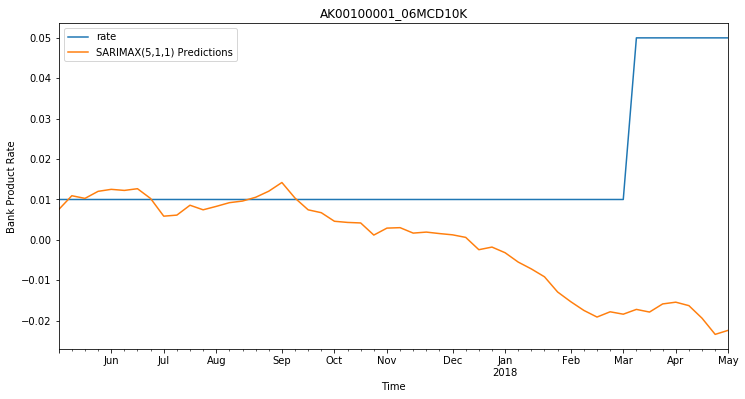

In [62]:
# DON'T WRITE HERE
title='AK00100001_06MCD10K'
ylabel='Bank Product Rate'
xlabel='Time'

ax = test['rate'].plot(legend=True,figsize=(12,6),title=title)
predictions_10YR_1YR.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

## Now add the exog variable-WGS10YR, WGS1YR and FF

In [63]:
auto_arima(df['rate'],exogenous=df[['WGS10YR','WGS1YR','FF']],seasonal=True,m=52).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  967
Model:               SARIMAX(2, 1, 1)   Log Likelihood                1320.847
Date:                Mon, 19 Aug 2019   AIC                          -2625.694
Time:                        12:36:19   BIC                          -2586.708
Sample:                             0   HQIC                         -2610.852
                                - 967                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0005      0.001     -1.051      0.293      -0.002       0.000
x1            -0.0213      0.019     -1.095      0.273      -0.059       0.017
x2            -0.0529      0.025     -2.123      0.034      -0.102      -0.004
x3             0.1049      0.010     10.914      0.000       0.086       0.124
ar.L1          0.7242      0.070     10.383      0.000       0.587       0.861
ar.L2          0.1588      0.041      3.835      0.000       0.078       0.240
ma.L1         -0.8156      0.045    -18.176      0.000      -0.904      -0.728
sigma2         0.0037   5.19e-05     71.952      0.000       0.004       0.004
===================================================================================
Ljung-Box (Q):                      110.85   Jarque-Bera (JB):             51010.43
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.01   Skew:                            -2.27
Prob(H) (two-sided):                  0.00   Kurtosis:                        38.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [64]:
model = SARIMAX(train['rate'],exog=train[['WGS10YR','WGS1YR','FF']],order=(2,1,1),enforce_invertibility=False)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                   rate   No. Observations:                  915
Model:               SARIMAX(2, 1, 1)   Log Likelihood                1212.669
Date:                Mon, 19 Aug 2019   AIC                          -2411.337
Time:                        12:37:10   BIC                          -2377.612
Sample:                    10-27-1999   HQIC                         -2398.464
                         - 05-03-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
WGS10YR       -0.0186      0.022     -0.854      0.393      -0.061       0.024
WGS1YR        -0.0458      0.030     -1.545      0.122      -0.104       0.012
FF             0.1144      0.011     10.583      0.000       0.093       0.136
ar.L1          0.5185      0.168      3.086      0.002       0.189       0.848
ar.L2          0.1105      0.040      2.737      0.006       0.031       0.190
ma.L1         -1.7976      0.494     -3.641      0.000      -2.765      -0.830
sigma2         0.0013      0.001      1.846      0.065   -7.92e-05       0.003
===================================================================================
Ljung-Box (Q):                      133.77   Jarque-Bera (JB):             45838.76
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.00   Skew:                            -2.45
Prob(H) (two-sided):                  0.00   Kurtosis:                        37.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [65]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
exog_forecast = test[['WGS10YR','WGS1YR','FF']]  
predictions_all = results.predict(start=start, end=end, exog=exog_forecast).rename('SARIMAX(2,1,1) Predictions')

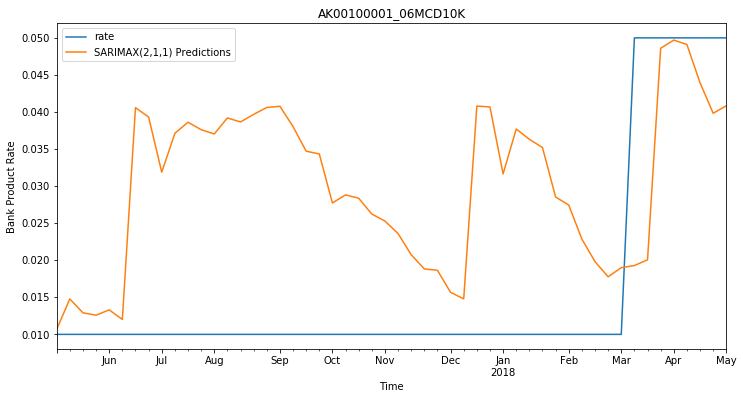

In [66]:
# DON'T WRITE HERE
title='AK00100001_06MCD10K'
ylabel='Bank Product Rate'
xlabel='Time'

ax = test['rate'].plot(legend=True,figsize=(12,6),title=title)
predictions_all.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

We can see that the exogenous variable (holidays) had a positive impact on the forecast by raising predicted values at 3/17, 4/14, 4/16 and 4/17! Let's compare evaluations:
### Evaluate the Model

In [95]:
# Print values from SARIMA above
print(f'SARIMA(2,1,1) MSE Error: {error1:11.10}')
print(f'SARIMA(2,1,1) RMSE Error: {error2:11.10}')
print()

error_FF1 = mse(test['rate'], predictions_FF)
error_FF2 = rmse(test['rate'], predictions_FF)


# Print new SARIMAX with FF values
print(f'SARIMAX(5,1,1)__FF MSE Error: {error_FF1:11.10}')
print(f'SARIMAX(5,1,1)_FF RMSE Error: {error_FF2:11.10}')
print()

error_1YR1 = mse(test['rate'], predictions_1YR)
error_1YR2 = rmse(test['rate'], predictions_1YR)

# Print new SARIMAX with WGS1YR values
print(f'SARIMAX(3,1,2)__1YR MSE Error: {error_1YR1:11.10}')
print(f'SARIMAX(3,1,2)_1YR RMSE Error: {error_1YR2:11.10}')
print()

error_10YR1 = mse(test['rate'], predictions_10YR)
error_10YR2 = rmse(test['rate'], predictions_10YR)

# Print new SARIMAX with WGS10YR values
print(f'SARIMAX(1,0,0)_10YR MSE Error: {error_10YR1:11.10}')
print(f'SARIMAX(1,0,0)_10YR RMSE Error: {error_10YR2:11.10}')
print()

error_10YR_1YR1 = mse(test['rate'], predictions_10YR_1YR)
error_10YR_1YR2 = rmse(test['rate'], predictions_10YR_1YR)

# Print new SARIMAX with WGS10YR and WGS10YR values
print(f'SARIMAX(5,1,1)10YR_1YR MSE Error: {error_10YR_1YR1:11.10}')
print(f'SARIMAX(5,1,1)10YR_1YR RMSE Error: {error_10YR_1YR2:11.10}')
print()

error_all1 = mse(test['rate'], predictions_all)
error_all2 = rmse(test['rate'], predictions_all)

# Print new SARIMAX with all values
print(f'SARIMAX(2,1,1)_all MSE Error: {error_all1:11.10}')
print(f'SARIMAX(2,1,1)_all RMSE Error: {error_all2:11.10}')

SARIMA(2,1,1) MSE Error: 0.0002461542697
SARIMA(2,1,1) RMSE Error: 0.01568930431

SARIMAX(5,1,1)__FF MSE Error: 0.0004017152327
SARIMAX(5,1,1)_FF RMSE Error: 0.02004283495

SARIMAX(3,1,2)__1YR MSE Error: 0.001530208486
SARIMAX(3,1,2)_1YR RMSE Error: 0.03911787936

SARIMAX(1,0,0)_10YR MSE Error: 0.0005388439508
SARIMAX(1,0,0)_10YR RMSE Error: 0.02321301253

SARIMAX(5,1,1)10YR_1YR MSE Error: 0.0008467843844
SARIMAX(5,1,1)10YR_1YR RMSE Error: 0.02909955987

SARIMAX(2,1,1)_all MSE Error: 0.0004112303469
SARIMAX(2,1,1)_all RMSE Error: 0.02027881522


In [96]:
labels=['error_rate','error_FF','error_1YR','error_10YR','error_10YR_1YR','error_all']
labels

['error_rate',
 'error_FF',
 'error_1YR',
 'error_10YR',
 'error_10YR_1YR',
 'error_all']

In [97]:
rate_MSE_error=np.array([error1,error_FF1,error_1YR1,error_10YR1,error_10YR_1YR1,error_all1])
df_rate_MSE_error=pd.DataFrame(data=rate_MSE_error,index=labels)
df_rate_MSE_error.columns=['MSE_error']
df_rate_MSE_error

,MSE_error
error_rate,0.000246
error_FF,0.000402
error_1YR,0.001530
error_10YR,0.000539
error_10YR_1YR,0.000847
error_all,0.000411


In [98]:
rate_RMSE_error=np.array([error2,error_FF2,error_1YR2,error_10YR2,error_10YR_1YR2,error_all2])
df_rate_RMSE_error=pd.DataFrame(data=rate_RMSE_error,index=labels)
df_rate_RMSE_error.columns=['RMSE_error']
df_rate_RMSE_error


,RMSE_error
error_rate,0.015689
error_FF,0.020043
error_1YR,0.039118
error_10YR,0.023213
error_10YR_1YR,0.029100
error_all,0.020279


In [100]:
error=df_rate_RMSE_error.join(df_rate_MSE_error)
error

,RMSE_error,MSE_error
error_rate,0.015689,0.000246
error_FF,0.020043,0.000402
error_1YR,0.039118,0.001530
error_10YR,0.023213,0.000539
error_10YR_1YR,0.029100,0.000847
error_all,0.020279,0.000411


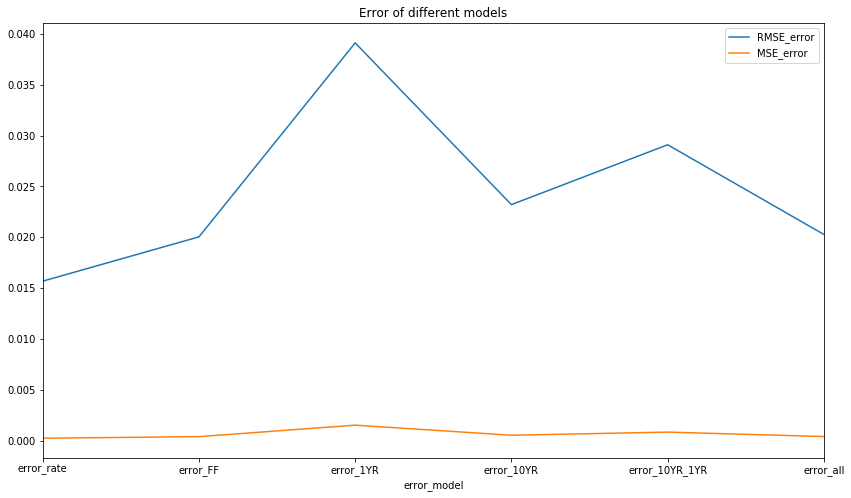

In [101]:
title='Error of different models'
ylabel=''
xlabel='error_model'

ax = error.plot(legend=True,figsize=(14,8),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [103]:
error.iplot()

## From the above plot, we can see that the basic Seasonal AutoRegressive Integrated Moving Average without  exogenous considered have the lowest Root Mean Square Error(RMSE) and Mean squared error(MSE).We will use this basic model to forecaste the future


### Retrain the model on the full data, and forecast the future
We're going to forecast 52 weeks into the future

In [105]:
model = SARIMAX(df['rate'],order=(2,1,1),enforce_invertibility=False)
results = model.fit()
fcast = results.predict(len(df),len(df)+51,exog=exog_forecast).rename('SARIMAX(2,1,1) Forecast')

[Text(0, 0.5, 'Rate'), Text(0.5, 0, 'Time')]

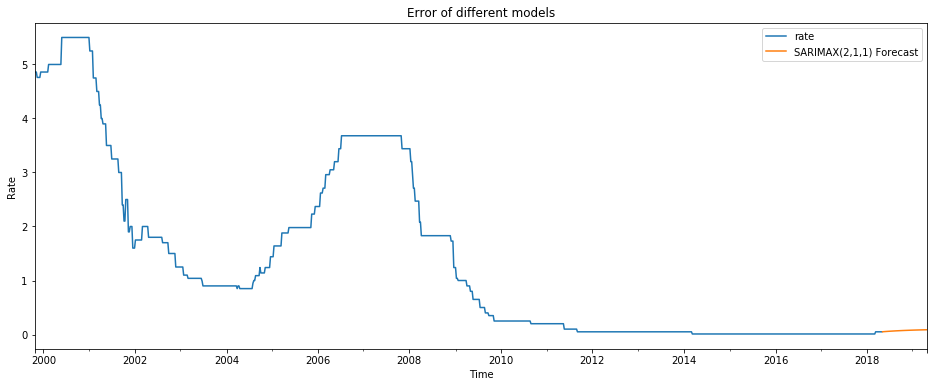

In [106]:
# Plot the forecast alongside historical values
title='Error of different models'
ylabel='Rate'
xlabel='Time'

ax = df['rate'].plot(legend=True,figsize=(16,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

## Comments: